# Installs and Imports

In [ ]:
!pip install torchmetrics -q

In [ ]:
# Standard Library Imports
import os
import random
import sys
import joblib
import gc
import requests
import h5py
from tqdm import tqdm
from io import BytesIO

# Data Handling Libraries
import numpy as np
import pandas as pd

# TensorFlow and Keras Imports
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow.keras.backend as K
from tensorflow.keras import layers, models, optimizers, regularizers, initializers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, AdamW
from tensorflow.keras.metrics import Metric
from tensorflow.data import Dataset
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import VGG16

# PyTorch Imports
import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import torchmetrics
from transformers import DeiTForImageClassificationWithTeacher, DeiTImageProcessor

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('darkgrid')
plt.style.use('ggplot')

# Image Processing Library
from PIL import Image

# Colab-specific Imports
from google.colab import drive

# Set Random Seeds for Reproducibility
os.environ['PYTHONHASHSEED'] = str(123)
random.seed(123)
np.random.seed(123)
tf.random.set_seed(123)
tf.config.experimental.enable_op_determinism()

# TensorFlow Session Configuration
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Loading the Data

In [ ]:
# Set the data directory
data_path = '/content/drive/My Drive/Datasets/animals-90/animals/animals'

In [ ]:
# Load images from the directory
full_dataset = image_dataset_from_directory(
    data_path,
    image_size=(224, 224),
    batch_size=None,
    shuffle=True,
    seed=123
)

Found 5416 files belonging to 90 classes.


In [ ]:
# Map class numbers to class names
class_names = sorted(os.listdir('/content/drive/My Drive/Datasets/animals-90/animals/animals'))
class_labels = {i: name for i, name in enumerate(class_names)}

# Preprocessing the Data

## Splitting

In [ ]:
# Define the batch size
batch_size = 16

# Compute dataset size
total_images = tf.data.experimental.cardinality(full_dataset).numpy()
print(f'Total images: {total_images}')

# Calculate splits
train_size = int(total_images * 0.7)
val_size = int(total_images * 0.15)
test_size = total_images - train_size - val_size

print('\n')
print(f'Train size: {train_size}')
print(f'Val size: {val_size}')
print(f'Test size: {test_size}')

# Check for remainders in validation and test sets
print('\n')
print(f'Remainder of val size divided by batch size: {val_size % batch_size}')
print(f'Remainder of test size divided by batch size: {test_size % batch_size}')

# Split the dataset
train_ds = full_dataset.take(train_size)
remaining_ds = full_dataset.skip(train_size)
val_ds = remaining_ds.take(val_size)
test_ds = remaining_ds.skip(val_size)

Total images: 5416


Train size: 3791
Val size: 812
Test size: 813


Remainder of val size divided by batch size: 12
Remainder of test size divided by batch size: 13


## Augmenting

In [ ]:
# Instantiate the augmentation layers
random_flip = tf.keras.layers.RandomFlip("horizontal_and_vertical")
random_rotation = tf.keras.layers.RandomRotation(0.2, fill_mode='reflect')
random_zoom = tf.keras.layers.RandomZoom(0.1)
random_brightness = tf.keras.layers.RandomBrightness(0.2)
random_contrast = tf.keras.layers.RandomContrast(factor=0.2)
random_translation = tf.keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1, fill_mode='reflect')
random_crop = tf.keras.layers.RandomCrop(height=224, width=224)

# Function for augmentation
def augment(image, label):
    """
    Randomly apply augmentations to a single image and resize back to original dimensions if necessary.
    Parameters:
    - image: TensorFlow tensor representing an image.
    - label: The label associated with the image.
    """
    # Randomly apply the instantiated layers
    if tf.random.uniform([]) > 0.3:
        image = random_flip(image)
    if tf.random.uniform([]) > 0.3:
        image = random_rotation(image)
    if tf.random.uniform([]) > 0.2:
        image = random_zoom(image)
    if tf.random.uniform([]) > 0.4:
        image = random_brightness(image)
    if tf.random.uniform([]) > 0.4:
        image = random_contrast(image)
    if tf.random.uniform([]) > 0.3:
        image = random_translation(image)

    # Apply random crop with a certain probability
    if tf.random.uniform([]) > 0.2:
        image = random_crop(tf.expand_dims(image, 0))
        image = tf.squeeze(image, 0)

    return image, label

## Normalizing

In [ ]:
# Apply normalization to datasets and configure them for performance
AUTOTUNE = tf.data.AUTOTUNE
normalization_layer = Rescaling(1./255)
num_classes = 90

# Function to process the images and labels
def process_dataset(image, label):
    # Normalize the images
    image = normalization_layer(image)

    # One-hot encode the labels
    label = tf.one_hot(tf.cast(label, tf.int32), num_classes)
    return image, label

# Apply normalization and one-hot encoding to datasets
train_ds_augmented = (
    train_ds
    .shuffle(1000)
    .map(augment, num_parallel_calls=AUTOTUNE)
    .map(process_dataset, num_parallel_calls=AUTOTUNE)
    .batch(batch_size, drop_remainder=True)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

val_ds = (
    val_ds
    .map(process_dataset, num_parallel_calls=AUTOTUNE)
    .batch(batch_size, drop_remainder=True)
    .prefetch(buffer_size=AUTOTUNE)
)

test_ds = (
    test_ds
    .map(process_dataset, num_parallel_calls=AUTOTUNE)
    .batch(batch_size, drop_remainder=True)
    .prefetch(buffer_size=AUTOTUNE)
)

## Verifying

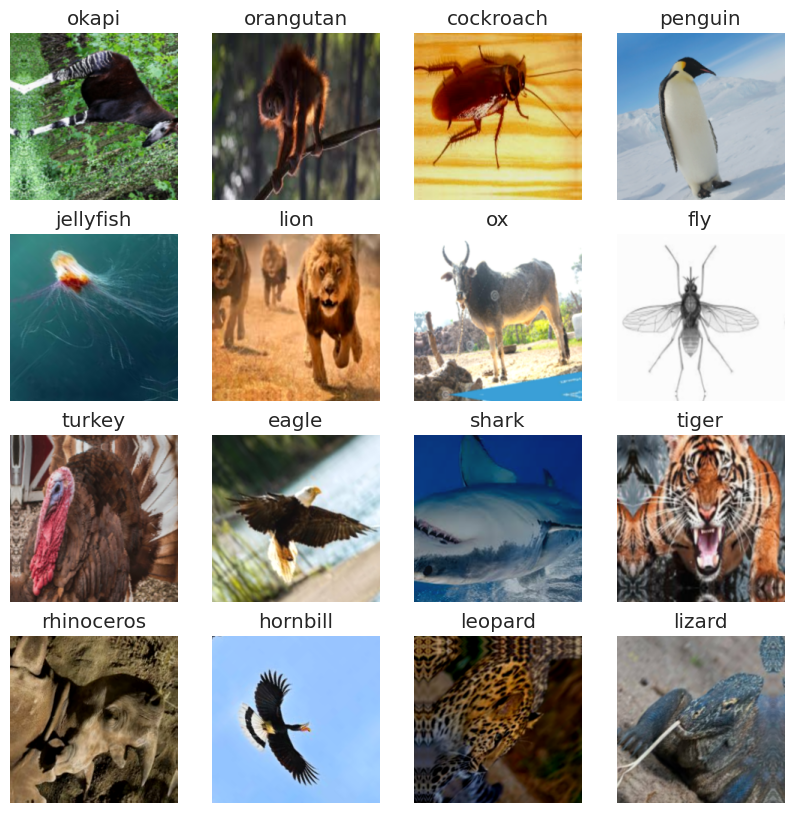

In [ ]:
# Function to view an image batch
def show_batch(image_batch, label_batch, class_labels):
    plt.figure(figsize=(10, 10))
    for n in range(16):
        ax = plt.subplot(4, 4, n + 1)
        plt.imshow((image_batch[n].numpy() * 255).astype("uint8"))
        label = label_batch[n].numpy()
        class_index = np.argmax(label)
        class_name = class_labels[class_index]
        plt.title(class_name)
        plt.axis("off")

# Display a batch of images from the training dataset
image_batch, label_batch = next(iter(train_ds_augmented))
show_batch(image_batch, label_batch, class_labels)

In [ ]:
# Check for the expected batched shapes
for images, labels in train_ds_augmented.take(1):
    print(images.shape, labels.shape)

for images, labels in val_ds.take(1):
    print(images.shape, labels.shape)

for images, labels in test_ds.take(1):
    print(images.shape, labels.shape)

(16, 224, 224, 3) (16, 90)
(16, 224, 224, 3) (16, 90)
(16, 224, 224, 3) (16, 90)


In [ ]:
# Check the number of batches in each set
num_batches_train = tf.data.experimental.cardinality(train_ds_augmented).numpy()
print(f"Number of training set batches: {num_batches_train}")

num_batches_val = tf.data.experimental.cardinality(val_ds).numpy()
print(f"Number of validation set batches: {num_batches_val}")

num_batches_test = tf.data.experimental.cardinality(test_ds).numpy()
print(f"Number of test set batches: {num_batches_test}")

Number of training set batches: 236
Number of validation set batches: 50
Number of test set batches: 50


# Creating the Models

In [ ]:
# Set the number of epochs
epochs = 10

In [ ]:
# Instantiate the metrics
recall = tf.keras.metrics.Recall(name='recall')
precision = tf.keras.metrics.Precision(name='precision')
f1_score = tf.keras.metrics.F1Score(name='f1_score', average='macro')
roc_auc = tf.keras.metrics.AUC(name='roc_auc', curve='roc', multi_label=True, num_labels=90)

In [ ]:
# Function to plot accuracy and loss
def plot_training_history(history, model_name="Model"):
    """
    Plots the training history of a model.
    """
    plt.figure(figsize=(12, 4))
    epochs_range = range(1, len(history.history['loss']) + 1)

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, history.history['loss'], label='Train Loss')
    plt.plot(epochs_range, history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Metrics
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, history.history['val_accuracy'], label='Accuracy')
    plt.plot(epochs_range, history.history['val_recall'], label='Recall')
    plt.plot(epochs_range, history.history['val_precision'], label='Precision')
    plt.plot(epochs_range, history.history['val_f1_score'], label='F1 Score')
    plt.plot(epochs_range, history.history['val_roc_auc'], label='ROC-AUC')
    plt.title(f'{model_name} Metrics over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Metric Value')
    plt.legend()

    plt.show()

## Convolutional Model

In [ ]:
# Load VGG16 as the base model
base_model_vgg16 = VGG16(input_shape=(224, 224, 3), include_top=False, weights='imagenet', pooling='max')

# Freeze the base model
base_model_vgg16.trainable = False

# Add a Dense layer for classification
vgg16_model = tf.keras.Sequential([
    base_model_vgg16,
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [ ]:
# Compile the model
vgg16_model.compile(
    optimizer=tf.keras.optimizers.AdamW(),
    loss='categorical_crossentropy',
    metrics=['accuracy', recall, precision, f1_score, roc_auc]
)

# Model summary
vgg16_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 dense (Dense)               (None, 90)                46170     
                                                                 
Total params: 14760858 (56.31 MB)
Trainable params: 46170 (180.35 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [ ]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')
checkpoint_vgg = ModelCheckpoint('vgg16_best_model.tf', monitor='val_loss', mode='min', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.00001, mode='min', verbose=1)

# Fit the model
history_vgg16 = vgg16_model.fit(
    train_ds_augmented,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[early_stopping, checkpoint_vgg, reduce_lr]
)

# Load the best model
vgg16_model.load_weights('vgg16_best_model.tf')

# Evaluate the model
vgg16_results = vgg16_model.evaluate(val_ds)
print(f"VGG16 Model Results:\n"
      f"  Loss: {vgg16_results[0]:.4f}\n"
      f"  Accuracy: {vgg16_results[1]:.4f}\n"
      f"  Recall: {vgg16_results[2]:.4f}\n"
      f"  Precision: {vgg16_results[3]:.4f}\n"
      f"  F1-Score: {vgg16_results[4]:.4f}\n"
      f"  ROC-AUC: {vgg16_results[5]:.4f}")

Epoch 1/10
236/236 [==============================] - ETA: 0s - loss: 4.4373 - accuracy: 0.0538 - recall: 2.6483e-04 - precision: 1.0000 - f1_score: 0.0500 - roc_auc: 0.6336
Epoch 1: val_loss improved from inf to 3.72573, saving model to vgg16_best_model.tf
236/236 [==============================] - 111s 408ms/step - loss: 4.4373 - accuracy: 0.0538 - recall: 2.6483e-04 - precision: 1.0000 - f1_score: 0.0500 - roc_auc: 0.6336 - val_loss: 3.7257 - val_accuracy: 0.1338 - val_recall: 0.0025 - val_precision: 1.0000 - val_f1_score: 0.1044 - val_roc_auc: 0.8478 - lr: 0.0010
Epoch 2/10
236/236 [==============================] - ETA: 0s - loss: 3.6784 - accuracy: 0.1663 - recall: 0.0048 - precision: 0.9474 - f1_score: 0.1578 - roc_auc: 0.8017
Epoch 2: val_loss improved from 3.72573 to 3.17391, saving model to vgg16_best_model.tf
236/236 [==============================] - 105s 397ms/step - loss: 3.6784 - accuracy: 0.1663 - recall: 0.0048 - precision: 0.9474 - f1_score: 0.1578 - roc_auc: 0.8017 -

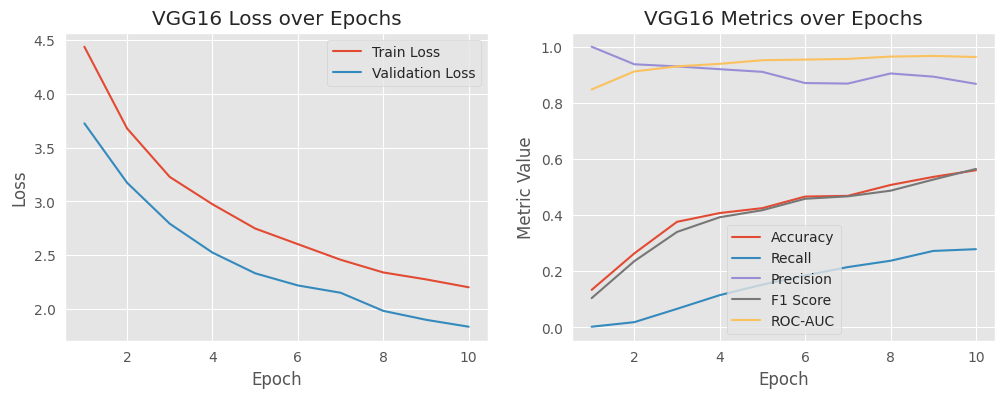

In [ ]:
# Plot the history
plot_training_history(history_vgg16, "VGG16")

In [ ]:
# Free up some memory
del base_model_vgg16, vgg16_model
gc.collect()

49037

## ResNet Model

In [ ]:
# Load the ResNet model
resnet_model_url = "https://tfhub.dev/google/imagenet/resnet_v2_101/feature_vector/4"
resnet_layer = hub.KerasLayer(resnet_model_url, input_shape=(224, 224, 3), trainable=False)

# Build the full model
resnet_model = tf.keras.Sequential([
    resnet_layer,
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [ ]:
# Compile the ResNet model
resnet_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy', recall, precision, f1_score, roc_auc]
)

# Model summary
resnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 2048)              42626560  
                                                                 
 dense_1 (Dense)             (None, 90)                184410    
                                                                 
Total params: 42810970 (163.31 MB)
Trainable params: 184410 (720.35 KB)
Non-trainable params: 42626560 (162.61 MB)
_________________________________________________________________


In [ ]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')
checkpoint_res = ModelCheckpoint('resnet101_best_model.tf', monitor='val_loss', mode='min', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.00001, mode='min', verbose=1)

# Fit the model
history_resnet = resnet_model.fit(
    train_ds_augmented,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[early_stopping, checkpoint_res, reduce_lr]
)

# Load the best model
resnet_model.load_weights('resnet101_best_model.tf')

# Evaluate the best model
resnet_results = resnet_model.evaluate(val_ds)
print(f"ResNet-101 Model Results:\n"
      f"  Loss: {resnet_results[0]:.4f}\n"
      f"  Accuracy: {resnet_results[1]:.4f}\n"
      f"  Recall: {resnet_results[2]:.4f}\n"
      f"  Precision: {resnet_results[3]:.4f}\n"
      f"  F1-Score: {resnet_results[4]:.4f}\n"
      f"  ROC-AUC: {resnet_results[5]:.4f}")

Epoch 1/10
236/236 [==============================] - ETA: 0s - loss: 2.2932 - accuracy: 0.4833 - recall: 0.3121 - precision: 0.8207 - f1_score: 0.4926 - roc_auc: 0.9194
Epoch 1: val_loss improved from inf to 0.68759, saving model to resnet101_best_model.tf
236/236 [==============================] - 128s 465ms/step - loss: 2.2932 - accuracy: 0.4833 - recall: 0.3121 - precision: 0.8207 - f1_score: 0.4926 - roc_auc: 0.9194 - val_loss: 0.6876 - val_accuracy: 0.8163 - val_recall: 0.7375 - val_precision: 0.9119 - val_f1_score: 0.8102 - val_roc_auc: 0.9877 - lr: 0.0010
Epoch 2/10
236/236 [==============================] - ETA: 0s - loss: 1.0226 - accuracy: 0.7248 - recall: 0.6425 - precision: 0.8566 - f1_score: 0.7215 - roc_auc: 0.9767
Epoch 2: val_loss improved from 0.68759 to 0.44013, saving model to resnet101_best_model.tf
236/236 [==============================] - 118s 457ms/step - loss: 1.0226 - accuracy: 0.7248 - recall: 0.6425 - precision: 0.8566 - f1_score: 0.7215 - roc_auc: 0.9767 -

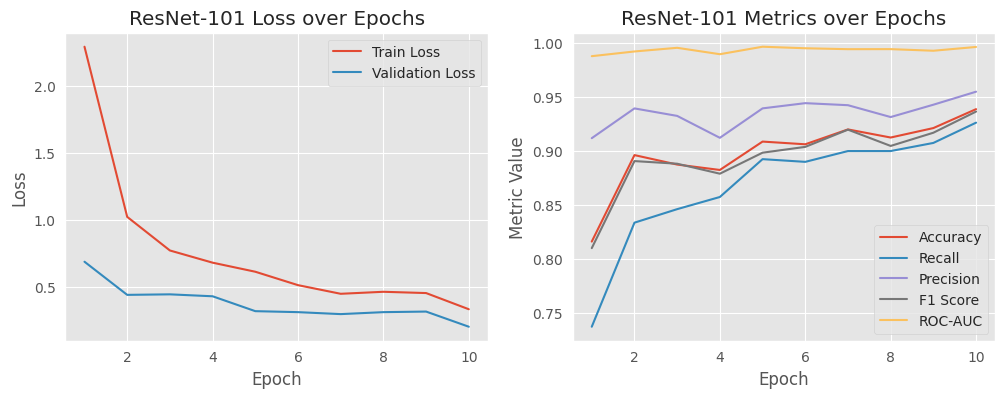

In [ ]:
# Plot the history
plot_training_history(history_resnet, "ResNet-101")

In [ ]:
# Free up some memory
del resnet_layer, resnet_model
gc.collect()

7367

## EfficientNet Model

In [ ]:
# Load the EfficientNet model
efficientnet_model_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"
efficientnet_layer = hub.KerasLayer(efficientnet_model_url, input_shape=(224, 224, 3), trainable=False)

# Build the full model
efficientnet_model = tf.keras.Sequential([
    efficientnet_layer,
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [ ]:
# Compile the EfficientNet model
efficientnet_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy', recall, precision, f1_score, roc_auc]
)

# Model summary
efficientnet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              4049564   
                                                                 
 dense_2 (Dense)             (None, 90)                115290    
                                                                 
Total params: 4164854 (15.89 MB)
Trainable params: 115290 (450.35 KB)
Non-trainable params: 4049564 (15.45 MB)
_________________________________________________________________


In [ ]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')
checkpoint_eff = ModelCheckpoint('efficientnet_best_model.tf', monitor='val_loss', mode='min', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.00001, mode='min', verbose=1)

# Fit the model
history_efficientnet = efficientnet_model.fit(
    train_ds_augmented,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[early_stopping, checkpoint_eff, reduce_lr]
)

# Load the best model
efficientnet_model.load_weights('efficientnet_best_model.tf')

# Evaluate the model
efficientnet_results = efficientnet_model.evaluate(val_ds)
print(f"EfficientNet Model Results:\n"
      f"  Loss: {efficientnet_results[0]:.4f}\n"
      f"  Accuracy: {efficientnet_results[1]:.4f}\n"
      f"  Recall: {efficientnet_results[2]:.4f}\n"
      f"  Precision: {efficientnet_results[3]:.4f}\n"
      f"  F1-Score: {efficientnet_results[4]:.4f}\n"
      f"  ROC-AUC: {efficientnet_results[5]:.4f}")

Epoch 1/10
236/236 [==============================] - ETA: 0s - loss: 2.3667 - accuracy: 0.5469 - recall: 0.2788 - precision: 0.9645 - f1_score: 0.6194 - roc_auc: 0.9560
Epoch 1: val_loss improved from inf to 0.89356, saving model to efficientnet_best_model.tf
236/236 [==============================] - 118s 415ms/step - loss: 2.3667 - accuracy: 0.5469 - recall: 0.2788 - precision: 0.9645 - f1_score: 0.6194 - roc_auc: 0.9560 - val_loss: 0.8936 - val_accuracy: 0.8400 - val_recall: 0.5325 - val_precision: 0.9838 - val_f1_score: 0.8326 - val_roc_auc: 0.9982 - lr: 0.0010
Epoch 2/10
236/236 [==============================] - ETA: 0s - loss: 0.8948 - accuracy: 0.8083 - recall: 0.5948 - precision: 0.9652 - f1_score: 0.8034 - roc_auc: 0.9939
Epoch 2: val_loss improved from 0.89356 to 0.50695, saving model to efficientnet_best_model.tf
236/236 [==============================] - 105s 401ms/step - loss: 0.8948 - accuracy: 0.8083 - recall: 0.5948 - precision: 0.9652 - f1_score: 0.8034 - roc_auc: 0.

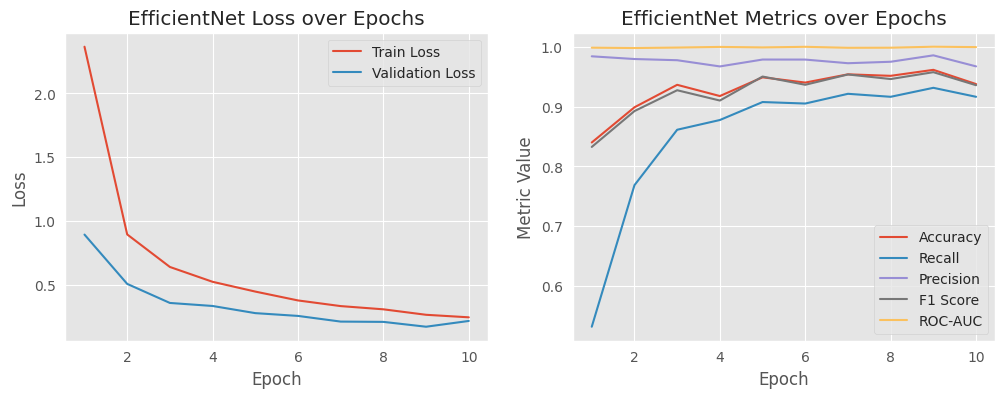

In [ ]:
# Plot the history
plot_training_history(history_efficientnet, "EfficientNet")

In [ ]:
# Free up some memory
del efficientnet_layer, efficientnet_model
gc.collect()

7325

## Inception Model

In [ ]:
# Load the Inception model
inception_model_url = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"
inception_layer = hub.KerasLayer(inception_model_url, input_shape=(299, 299, 3), trainable=False)

# Build the full model
inception_model = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Resizing(299, 299),
    inception_layer,
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [ ]:
# Compile the Inception Model
inception_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy', recall, precision, f1_score, roc_auc]
)

# Build so we can use the summary method
inception_model.build(input_shape=(None, 224, 224, 3))

# Model summary
inception_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 299, 299, 3)       0         
                                                                 
 keras_layer_2 (KerasLayer)  (None, 2048)              21802784  
                                                                 
 dense_3 (Dense)             (None, 90)                184410    
                                                                 
Total params: 21987194 (83.87 MB)
Trainable params: 184410 (720.35 KB)
Non-trainable params: 21802784 (83.17 MB)
_________________________________________________________________


In [ ]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')
checkpoint_inc = ModelCheckpoint('inception_best_model.tf', monitor='val_loss', mode='min', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.00001, mode='min', verbose=1)

# Fit the model
history_inception = inception_model.fit(
    train_ds_augmented,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[early_stopping, checkpoint_inc, reduce_lr]
)

# Load the best model
inception_model.load_weights('inception_best_model.tf')

# Evaluate the model
inception_results = inception_model.evaluate(val_ds)
print(f"Inception Model Results:\n"
      f"  Loss: {inception_results[0]:.4f}\n"
      f"  Accuracy: {inception_results[1]:.4f}\n"
      f"  Recall: {inception_results[2]:.4f}\n"
      f"  Precision: {inception_results[3]:.4f}\n"
      f"  F1-Score: {inception_results[4]:.4f}\n"
      f"  ROC-AUC: {inception_results[5]:.4f}")

Epoch 1/10
236/236 [==============================] - ETA: 0s - loss: 0.7553 - accuracy: 0.7979 - recall: 0.7068 - precision: 0.9115 - f1_score: 0.7968 - roc_auc: 0.9894
Epoch 1: val_loss improved from inf to 0.35897, saving model to inception_best_model.tf
236/236 [==============================] - 112s 430ms/step - loss: 0.7553 - accuracy: 0.7979 - recall: 0.7068 - precision: 0.9115 - f1_score: 0.7968 - roc_auc: 0.9894 - val_loss: 0.3590 - val_accuracy: 0.8975 - val_recall: 0.8487 - val_precision: 0.9431 - val_f1_score: 0.8901 - val_roc_auc: 0.9985 - lr: 0.0010
Epoch 2/10
236/236 [==============================] - ETA: 0s - loss: 0.6807 - accuracy: 0.8146 - recall: 0.7341 - precision: 0.9026 - f1_score: 0.8134 - roc_auc: 0.9903
Epoch 2: val_loss improved from 0.35897 to 0.32580, saving model to inception_best_model.tf
236/236 [==============================] - 113s 434ms/step - loss: 0.6807 - accuracy: 0.8146 - recall: 0.7341 - precision: 0.9026 - f1_score: 0.8134 - roc_auc: 0.9903 -

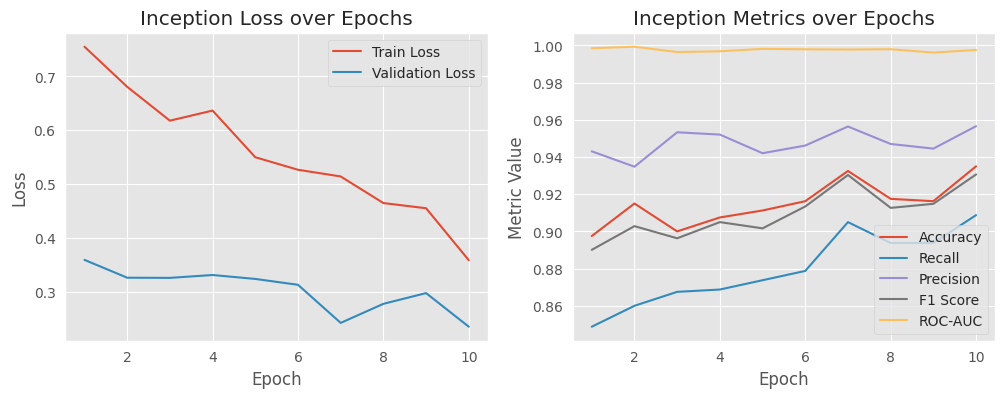

In [ ]:
# Plot the history
plot_training_history(history_inception, "Inception")

In [ ]:
# Free up some memory
del inception_layer, inception_model
gc.collect()

341546

## Transformer Model

In [ ]:
# Load the Vision Transformer model
vit_model_url = "https://www.kaggle.com/models/spsayakpaul/vision-transformer/frameworks/TensorFlow2/variations/vit-s16-classification/versions/1"
vit_layer = hub.KerasLayer(vit_model_url, input_shape=(224, 224, 3), trainable=False)

# Build the full model
vit_model = tf.keras.Sequential([
    vit_layer,
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [ ]:
# Compile the ViT Model
vit_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy', recall, precision, f1_score, roc_auc]
)

# Model summary
vit_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_3 (KerasLayer)  (None, 1000)              22050664  
                                                                 
 dense_4 (Dense)             (None, 90)                90090     
                                                                 
Total params: 22140754 (84.46 MB)
Trainable params: 90090 (351.91 KB)
Non-trainable params: 22050664 (84.12 MB)
_________________________________________________________________


In [ ]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')
checkpoint_vit = ModelCheckpoint('vits16_best_model.tf', monitor='val_loss', mode='min', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.00001, mode='min', verbose=1)

# Fit the model
history_vit = vit_model.fit(
    train_ds_augmented,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[early_stopping, checkpoint_vit, reduce_lr]
)

# Load the best model
vit_model.load_weights('vits16_best_model.tf')

# Evaluate the model
vit_results = vit_model.evaluate(val_ds)
print(f"Vision Transformer Model Results:\n"
      f"  Loss: {vit_results[0]:.4f}\n"
      f"  Accuracy: {vit_results[1]:.4f}\n"
      f"  Recall: {vit_results[2]:.4f}\n"
      f"  Precision: {vit_results[3]:.4f}\n"
      f"  F1-Score: {vit_results[4]:.4f}\n"
      f"  ROC-AUC: {vit_results[5]:.4f}")

Epoch 1/10
236/236 [==============================] - ETA: 0s - loss: 1.7980 - accuracy: 0.6020 - recall: 0.5894 - precision: 0.8365 - f1_score: 0.6580 - roc_auc: 0.9440
Epoch 1: val_loss improved from inf to 0.27867, saving model to vits16_best_model.tf
236/236 [==============================] - 113s 416ms/step - loss: 1.7980 - accuracy: 0.6020 - recall: 0.5894 - precision: 0.8365 - f1_score: 0.6580 - roc_auc: 0.9440 - val_loss: 0.2787 - val_accuracy: 0.9212 - val_recall: 0.8988 - val_precision: 0.9448 - val_f1_score: 0.9180 - val_roc_auc: 0.9970 - lr: 0.0010
Epoch 2/10
236/236 [==============================] - ETA: 0s - loss: 0.7328 - accuracy: 0.8175 - recall: 0.7815 - precision: 0.8825 - f1_score: 0.8156 - roc_auc: 0.9800
Epoch 2: val_loss improved from 0.27867 to 0.20321, saving model to vits16_best_model.tf
236/236 [==============================] - 107s 411ms/step - loss: 0.7328 - accuracy: 0.8175 - recall: 0.7815 - precision: 0.8825 - f1_score: 0.8156 - roc_auc: 0.9800 - val_l

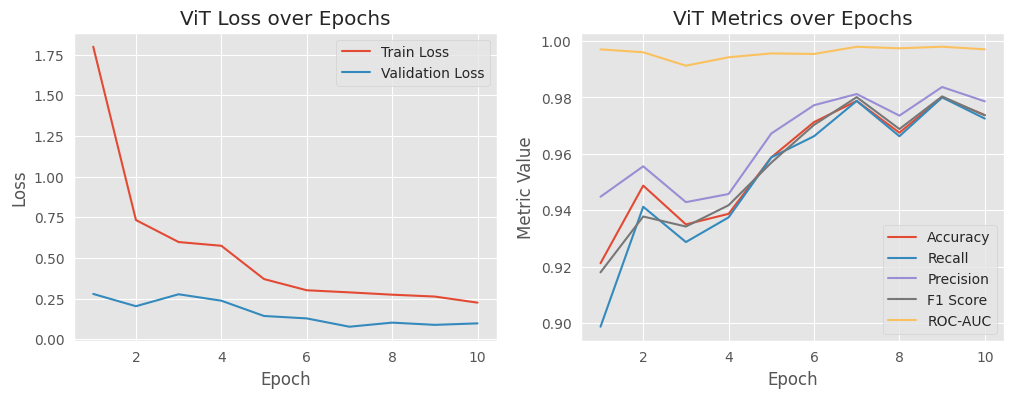

In [ ]:
# Plot the history
plot_training_history(history_vit, "ViT")

In [ ]:
# Free up some memory
del vit_layer, vit_model
gc.collect()

69108

## PyTorch DeiT Model

In [ ]:
# Function to save the TensorFlow datasets
def save_tf_dataset_to_hdf5(tf_dataset, filename, max_samples=None):
    """
    Saves a batched TensorFlow dataset to an HDF5 file.

    Parameters:
    - tf_dataset: Batched TensorFlow dataset to be saved.
    - filename: Name of the HDF5 file.
    - max_samples: Maximum number of samples to save (optional).
    """
    with h5py.File(filename, 'w') as h5f:
        for batch_id, (image_batch, label_batch) in enumerate(tf_dataset):
            if max_samples and batch_id >= max_samples:
                break
            h5f.create_dataset(f'image_batch_{batch_id}', data=image_batch.numpy())
            h5f.create_dataset(f'label_batch_{batch_id}', data=label_batch.numpy())

# Save the datasets
save_tf_dataset_to_hdf5(train_ds_augmented, 'train_dataset.h5')
save_tf_dataset_to_hdf5(val_ds, 'val_dataset.h5')
save_tf_dataset_to_hdf5(test_ds, 'test_dataset.h5')

In [ ]:
# Class to import saved Tensorflow datasets
class HDF5Dataset(Dataset):
    """
    A class for loading data from HDF5 files.
    """
    def __init__(self, file_path):
        self.file_path = file_path
        with h5py.File(file_path, 'r') as h5f:
            # Number of batches is half the number of keys (image and label pairs)
            self.num_batches = len(h5f.keys()) // 2

    def __len__(self):
        return self.num_batches

    def __getitem__(self, idx):
        with h5py.File(self.file_path, 'r') as h5f:
            image_batch = np.array(h5f[f'image_batch_{idx}'])
            label_batch = np.array(h5f[f'label_batch_{idx}'])
        return torch.from_numpy(image_batch).float(), torch.from_numpy(label_batch).long()

# Data loaders setup
train_dataset = HDF5Dataset('train_dataset.h5')
val_dataset = HDF5Dataset('val_dataset.h5')
test_dataset = HDF5Dataset('test_dataset.h5')

train_loader = DataLoader(train_dataset, batch_size=None, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=None, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=None, shuffle=False)

In [ ]:
# Function to check DataLoader dimensions
def check_data_loader_dimensions(loader):
    for batch in loader:
        images, labels = batch
        print("Images shape:", images.shape)
        print("Labels shape:", labels.shape)
        break

print("Train Loader:")
check_data_loader_dimensions(train_loader)

print("\nValidation Loader:")
check_data_loader_dimensions(val_loader)

print("\nTest Loader:")
check_data_loader_dimensions(test_loader)

Train Loader:
Images shape: torch.Size([16, 224, 224, 3])
Labels shape: torch.Size([16, 90])

Validation Loader:
Images shape: torch.Size([16, 224, 224, 3])
Labels shape: torch.Size([16, 90])

Test Loader:
Images shape: torch.Size([16, 224, 224, 3])
Labels shape: torch.Size([16, 90])


In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

# Initialize model and feature extractor
deit_model = DeiTForImageClassificationWithTeacher.from_pretrained(
    'facebook/deit-base-distilled-patch16-224',
    num_labels=90,
    ignore_mismatched_sizes=True
).to(device)
feature_extractor = DeiTImageProcessor.from_pretrained('facebook/deit-base-distilled-patch16-224')

Using cuda device


config.json:   0%|          | 0.00/69.6k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/349M [00:00<?, ?B/s]

Some weights of DeiTForImageClassificationWithTeacher were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized because the shapes did not match:
- cls_classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([90, 768]) in the model instantiated
- cls_classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([90]) in the model instantiated
- distillation_classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([90, 768]) in the model instantiated
- distillation_classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([90]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

In [ ]:
# Define the number of epochs
num_epochs = epochs

# Define optimizer and criterion
optimizer = torch.optim.AdamW(deit_model.parameters(), lr=5e-5)
criterion = torch.nn.CrossEntropyLoss()

# Define learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

In [ ]:
# Metrics initialization
accuracy_metric = torchmetrics.Accuracy(num_classes=num_classes, task='multiclass').to(device)
recall_metric = torchmetrics.Recall(num_classes=num_classes, task='multiclass', average='macro').to(device)
precision_metric = torchmetrics.Precision(num_classes=num_classes, task='multiclass', average='macro').to(device)
f1_metric = torchmetrics.F1Score(num_classes=num_classes, task='multiclass', average='macro').to(device)
roc_metric = torchmetrics.AUROC(num_classes=num_classes, task='multiclass', average='macro').to(device)

In [ ]:
# Dictionary for storing metrics history
history_deit = {
    'train_loss': [], 'val_loss': [],
    'train_accuracy': [], 'val_accuracy': [],
    'train_recall': [], 'val_recall': [],
    'train_precision': [], 'val_precision': [],
    'train_f1_score': [], 'val_f1_score': [],
    'train_roc_auc': [], 'val_roc_auc': []
}

# Initialize best_val_loss and best_metrics
best_val_loss = float('inf')
best_metrics = {'accuracy': 0, 'recall': 0, 'precision': 0, 'f1_score': 0, 'roc_auc': 0}

# Training loop
for epoch in range(num_epochs):
    deit_model.train()
    batch_count = 0
    total_train_loss = 0.0
    train_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}, Training")

    # Training phase
    for images, labels in train_tqdm:
        # Reorder the dimensions of the images
        images = images.permute(0, 3, 1, 2).to(device)

        # Convert one-hot encoded labels to class indices
        labels = torch.max(labels, 1)[1].to(device)

        # Zero gradients, forward pass, compute loss, backpropagation
        optimizer.zero_grad()
        outputs = deit_model(images)
        loss = criterion(outputs.logits, labels)
        loss.backward()
        optimizer.step()

        # Update total loss and metrics
        total_train_loss += loss.item()
        accuracy_metric.update(outputs.logits, labels)
        recall_metric.update(outputs.logits, labels)
        precision_metric.update(outputs.logits, labels)
        f1_metric.update(outputs.logits, labels)
        roc_metric.update(outputs.logits, labels)

        # Increment the batch counter
        batch_count += 1

        # Update the tqdm progress bar with current batch metrics
        train_tqdm.set_postfix(loss=total_train_loss / batch_count,
                               accuracy=accuracy_metric.compute().item(),
                               recall=recall_metric.compute().item(),
                               precision=precision_metric.compute().item(),
                               f1_score=f1_metric.compute().item(),
                               roc_auc=roc_metric.compute().item())

    # Calculate and store average training metrics for the epoch
    avg_train_loss = total_train_loss / len(train_loader)
    history_deit['train_loss'].append(avg_train_loss)
    history_deit['train_accuracy'].append(accuracy_metric.compute().item())
    history_deit['train_recall'].append(recall_metric.compute().item())
    history_deit['train_precision'].append(precision_metric.compute().item())
    history_deit['train_f1_score'].append(f1_metric.compute().item())
    history_deit['train_roc_auc'].append(roc_metric.compute().item())

    # Reset metrics for next epoch
    accuracy_metric.reset()
    recall_metric.reset()
    precision_metric.reset()
    f1_metric.reset()
    roc_metric.reset()

    # Validation phase
    deit_model.eval()
    batch_count = 0
    total_val_loss = 0.0
    val_tqdm = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs}, Validation")

    # Validation steps
    for images, labels in val_tqdm:
        images = images.permute(0, 3, 1, 2).to(device)
        labels = torch.max(labels, 1)[1].to(device)

        with torch.no_grad():
            outputs = deit_model(images)
            loss = criterion(outputs.logits, labels)
            total_val_loss += loss.item()

            # Update metrics
            accuracy_metric.update(outputs.logits, labels)
            recall_metric.update(outputs.logits, labels)
            precision_metric.update(outputs.logits, labels)
            f1_metric.update(outputs.logits, labels)
            roc_metric.update(outputs.logits, labels)

            # Increment the batch counter
            batch_count += 1

            # Update the tqdm progress bar with current batch metrics
            val_tqdm.set_postfix(loss=total_val_loss / batch_count,
                                 accuracy=accuracy_metric.compute().item(),
                                 recall=recall_metric.compute().item(),
                                 precision=precision_metric.compute().item(),
                                 f1_score=f1_metric.compute().item(),
                                 roc_auc=roc_metric.compute().item())

    # Calculate and store average validation metrics for the epoch
    avg_val_loss = total_val_loss / len(val_loader)
    history_deit['val_loss'].append(avg_val_loss)
    history_deit['val_accuracy'].append(accuracy_metric.compute().item())
    history_deit['val_recall'].append(recall_metric.compute().item())
    history_deit['val_precision'].append(precision_metric.compute().item())
    history_deit['val_f1_score'].append(f1_metric.compute().item())
    history_deit['val_roc_auc'].append(roc_metric.compute().item())

    # Update learning rate
    scheduler.step()

    # Check and save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_metrics['accuracy'] = accuracy_metric.compute().item()
        best_metrics['recall'] = recall_metric.compute().item()
        best_metrics['precision'] = precision_metric.compute().item()
        best_metrics['f1_score'] = f1_metric.compute().item()
        best_metrics['roc_auc'] = roc_metric.compute().item()
        torch.save(deit_model.state_dict(), 'best_deit_model.pth')

    # Print epoch summary
    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

# Print the best metrics
print(f"DeiT Model Results:\n"
      f"  Loss: {best_val_loss:.4f}\n"
      f"  Accuracy: {best_metrics['accuracy']:.4f}\n"
      f"  Recall: {best_metrics['recall']:.4f}\n"
      f"  Precision: {best_metrics['precision']:.4f}\n"
      f"  F1 Score: {best_metrics['f1_score']:.4f}\n"
      f"  ROC-AUC: {best_metrics['roc_auc']:.4f}")

Epoch 1/10, Training:   0%|          | 0/236 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
Epoch 1/10, Validation: 100%|██████████| 50/50 [00:12<00:00,  4.16it/s, accuracy=0.885, f1_score=0.881, loss=0.726, precision=0.897, recall=0.887, roc_auc=0.999]


Epoch [1/10] - Train Loss: 2.6437, Val Loss: 0.7258


Epoch 2/10, Validation: 100%|██████████| 50/50 [00:12<00:00,  4.03it/s, accuracy=0.92, f1_score=0.918, loss=0.559, precision=0.926, recall=0.924, roc_auc=0.999]


Epoch [2/10] - Train Loss: 0.5054, Val Loss: 0.5594


Epoch 3/10, Validation: 100%|██████████| 50/50 [00:12<00:00,  4.15it/s, accuracy=0.921, f1_score=0.92, loss=0.549, precision=0.928, recall=0.926, roc_auc=0.999]


Epoch [3/10] - Train Loss: 0.3734, Val Loss: 0.5487


Epoch 4/10, Validation: 100%|██████████| 50/50 [00:12<00:00,  4.15it/s, accuracy=0.921, f1_score=0.92, loss=0.548, precision=0.928, recall=0.926, roc_auc=0.999]


Epoch [4/10] - Train Loss: 0.3623, Val Loss: 0.5477


Epoch 5/10, Validation: 100%|██████████| 50/50 [00:12<00:00,  4.15it/s, accuracy=0.921, f1_score=0.92, loss=0.548, precision=0.928, recall=0.926, roc_auc=0.999]


Epoch [5/10] - Train Loss: 0.3611, Val Loss: 0.5476


Epoch 6/10, Validation: 100%|██████████| 50/50 [00:12<00:00,  4.14it/s, accuracy=0.921, f1_score=0.92, loss=0.548, precision=0.928, recall=0.926, roc_auc=0.999]


Epoch [6/10] - Train Loss: 0.3610, Val Loss: 0.5476


Epoch 7/10, Validation: 100%|██████████| 50/50 [00:12<00:00,  4.16it/s, accuracy=0.921, f1_score=0.92, loss=0.548, precision=0.928, recall=0.926, roc_auc=0.999]


Epoch [7/10] - Train Loss: 0.3610, Val Loss: 0.5476


Epoch 8/10, Validation: 100%|██████████| 50/50 [00:12<00:00,  4.12it/s, accuracy=0.921, f1_score=0.92, loss=0.548, precision=0.928, recall=0.926, roc_auc=0.999]


Epoch [8/10] - Train Loss: 0.3610, Val Loss: 0.5476


Epoch 9/10, Validation: 100%|██████████| 50/50 [00:12<00:00,  4.13it/s, accuracy=0.921, f1_score=0.92, loss=0.548, precision=0.928, recall=0.926, roc_auc=0.999]


Epoch [9/10] - Train Loss: 0.3610, Val Loss: 0.5476


Epoch 10/10, Validation: 100%|██████████| 50/50 [00:12<00:00,  4.12it/s, accuracy=0.921, f1_score=0.92, loss=0.548, precision=0.928, recall=0.926, roc_auc=0.999]


Epoch [10/10] - Train Loss: 0.3610, Val Loss: 0.5476
DeiT Model Results:
  Loss: 0.5476
  Accuracy: 0.9212
  Recall: 0.9256
  Precision: 0.9280
  F1 Score: 0.9198
  ROC-AUC: 0.9994


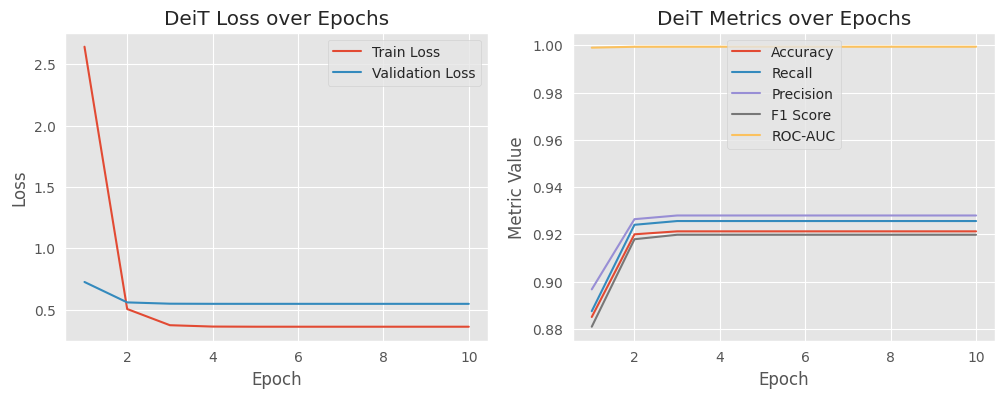

In [ ]:
# Plot metrics
plt.figure(figsize=(12, 4))
epochs_range = range(1, num_epochs + 1)

plt.subplot(1, 2, 1)
plt.plot(epochs_range, history_deit['train_loss'], label='Train Loss')
plt.plot(epochs_range, history_deit['val_loss'], label='Validation Loss')
plt.title('DeiT Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, history_deit['val_accuracy'], label='Accuracy')
plt.plot(epochs_range, history_deit['val_recall'], label='Recall')
plt.plot(epochs_range, history_deit['val_precision'], label='Precision')
plt.plot(epochs_range, history_deit['val_f1_score'], label='F1 Score')
plt.plot(epochs_range, history_deit['val_roc_auc'], label='ROC-AUC')
plt.title('DeiT Metrics over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.legend()
plt.show()

In [ ]:
# Clear memory
del deit_model, feature_extractor
gc.collect()

7523

# Model Selection

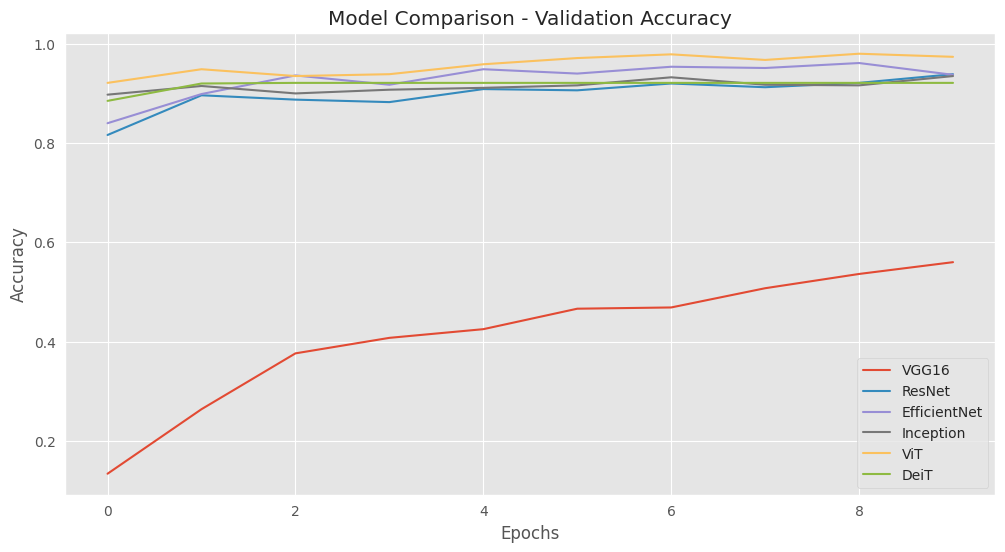

In [ ]:
# Model comparison plot
plt.figure(figsize=(12, 6))

# Plot validation accuracy for each model
plt.plot(history_vgg16.history['val_accuracy'], label='VGG16')
plt.plot(history_resnet.history['val_accuracy'], label='ResNet')
plt.plot(history_efficientnet.history['val_accuracy'], label='EfficientNet')
plt.plot(history_inception.history['val_accuracy'], label='Inception')
plt.plot(history_vit.history['val_accuracy'], label='ViT')

# Plot validation accuracy for PyTorch model
plt.plot(history_deit['val_accuracy'], label='DeiT')

plt.title('Model Comparison - Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

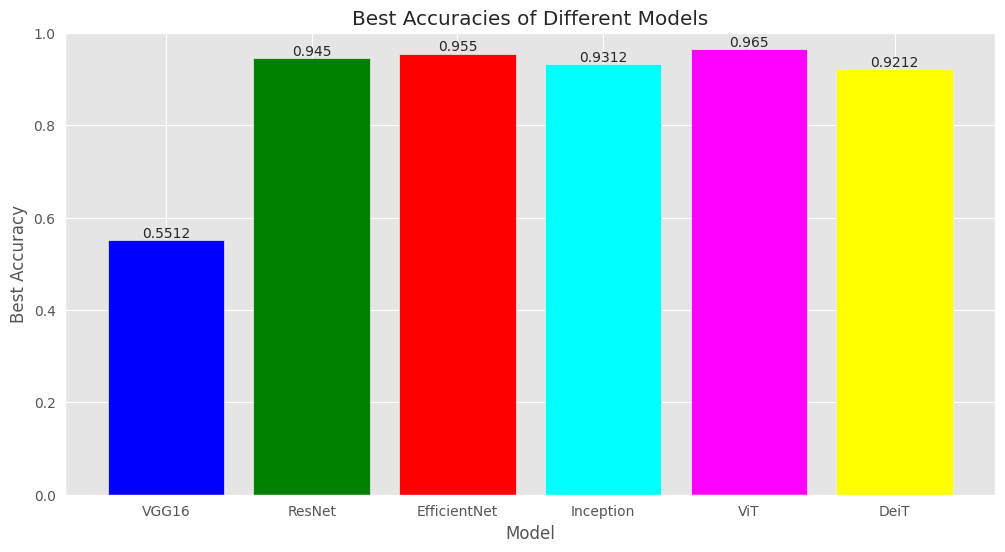

In [ ]:
# Plot the best accuracy metrics
best_accuracies = {
    'VGG16': vgg16_results[1],
    'ResNet': resnet_results[1],
    'EfficientNet': efficientnet_results[1],
    'Inception': inception_results[1],
    'ViT': vit_results[1],
    'DeiT': best_metrics['accuracy']
}

# Create the bar chart
plt.figure(figsize=(12, 6))
bars = plt.bar(best_accuracies.keys(), best_accuracies.values(), color=['blue', 'green', 'red', 'cyan', 'magenta', 'yellow'])

# Add the metric numbers on the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, round(yval, 4), va='bottom', ha='center')

plt.xlabel('Model')
plt.ylabel('Best Accuracy')
plt.title('Best Accuracies of Different Models')
plt.ylim([0.0, 1.0])
plt.show()

# Optimizer Fine-Tuning

In [ ]:
# Load the pretrained ViT model
vit_model_adam = tf.keras.models.load_model('vits16_best_model.tf')

# Compile the model with Adam optimizer
vit_model_adam.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy', recall, precision, f1_score, roc_auc]
)

# Model summary
vit_model_adam.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_3 (KerasLayer)  (None, 1000)              384000    
                                                                 
 dense_4 (Dense)             (None, 90)                90090     
                                                                 
Total params: 474090 (1.81 MB)
Trainable params: 90090 (351.91 KB)
Non-trainable params: 384000 (1.46 MB)
_________________________________________________________________


In [ ]:
# Evaluate the model
vit_results_adam = vit_model_adam.evaluate(test_ds)
print(f"Test Performance with Adam:\n"
      f"  Loss: {vit_results_adam[0]:.4f}\n"
      f"  Accuracy: {vit_results_adam[1]:.4f}\n"
      f"  Recall: {vit_results_adam[2]:.4f}\n"
      f"  Precision: {vit_results_adam[3]:.4f}\n"
      f"  F1-Score: {vit_results_adam[4]:.4f}\n"
      f"  ROC-AUC: {vit_results_adam[5]:.4f}")

50/50 [==============================] - 18s 58ms/step - loss: 0.0993 - accuracy: 0.9688 - recall: 0.9613 - precision: 0.9669 - f1_score: 0.9648 - roc_auc: 0.9965
Test Performance with Adam:
  Loss: 0.0993
  Accuracy: 0.9688
  Recall: 0.9613
  Precision: 0.9669
  F1-Score: 0.9648
  ROC-AUC: 0.9965


In [ ]:
# Lion optimizer from https://github.com/google/automl/tree/master/lion#readme
from lion_tf2 import Lion

# Load the pretrained ViT model
vit_model_lion = tf.keras.models.load_model('vits16_best_model.tf')

# Compile the model with Lion optimizer
vit_model_lion.compile(
    optimizer=Lion(),
    loss='categorical_crossentropy',
    metrics=['accuracy', recall, precision, f1_score, roc_auc]
)

# Model summary
vit_model_lion.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_3 (KerasLayer)  (None, 1000)              384000    
                                                                 
 dense_4 (Dense)             (None, 90)                90090     
                                                                 
Total params: 474090 (1.81 MB)
Trainable params: 90090 (351.91 KB)
Non-trainable params: 384000 (1.46 MB)
_________________________________________________________________


In [ ]:
# Evaluate the model
vit_results_lion = vit_model_lion.evaluate(test_ds)
print(f"Test Performance with Lion:\n"
      f"  Loss: {vit_results_lion[0]:.4f}\n"
      f"  Accuracy: {vit_results_lion[1]:.4f}\n"
      f"  Recall: {vit_results_lion[2]:.4f}\n"
      f"  Precision: {vit_results_lion[3]:.4f}\n"
      f"  F1-Score: {vit_results_lion[4]:.4f}\n"
      f"  ROC-AUC: {vit_results_lion[5]:.4f}")

50/50 [==============================] - 17s 59ms/step - loss: 0.1369 - accuracy: 0.9650 - recall: 0.9616 - precision: 0.9673 - f1_score: 0.9655 - roc_auc: 0.9964
Test Performance with Lion:
  Loss: 0.1369
  Accuracy: 0.9650
  Recall: 0.9616
  Precision: 0.9673
  F1-Score: 0.9655
  ROC-AUC: 0.9964


In [ ]:
# Load the pretrained ViT model
vit_model_sgd = tf.keras.models.load_model('vits16_best_model.tf')

# Compile the model with SGD optimizer
vit_model_sgd.compile(
    optimizer='sgd',
    loss='categorical_crossentropy',
    metrics=['accuracy', recall, precision, f1_score, roc_auc]
)

# Model summary
vit_model_sgd.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_3 (KerasLayer)  (None, 1000)              384000    
                                                                 
 dense_4 (Dense)             (None, 90)                90090     
                                                                 
Total params: 474090 (1.81 MB)
Trainable params: 90090 (351.91 KB)
Non-trainable params: 384000 (1.46 MB)
_________________________________________________________________


In [ ]:
# Evaluate the model
vit_results_sgd = vit_model_sgd.evaluate(test_ds)
print(f"Test Performance with SGD:\n"
      f"  Loss: {vit_results_sgd[0]:.4f}\n"
      f"  Accuracy: {vit_results_sgd[1]:.4f}\n"
      f"  Recall: {vit_results_sgd[2]:.4f}\n"
      f"  Precision: {vit_results_sgd[3]:.4f}\n"
      f"  F1-Score: {vit_results_sgd[4]:.4f}\n"
      f"  ROC-AUC: {vit_results_sgd[5]:.4f}")

50/50 [==============================] - 18s 59ms/step - loss: 0.0929 - accuracy: 0.9737 - recall: 0.9638 - precision: 0.9693 - f1_score: 0.9674 - roc_auc: 0.9965
Test Performance with SGD:
  Loss: 0.0929
  Accuracy: 0.9737
  Recall: 0.9638
  Precision: 0.9693
  F1-Score: 0.9674
  ROC-AUC: 0.9965


In [ ]:
# Load the pretrained ViT model
vit_model_rms = tf.keras.models.load_model('vits16_best_model.tf')

# Compile the model with RMSProp optimizer
vit_model_rms.compile(
    optimizer='rmsprop',
    loss='categorical_crossentropy',
    metrics=['accuracy', recall, precision, f1_score, roc_auc]
)

# Model summary
vit_model_rms.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_3 (KerasLayer)  (None, 1000)              384000    
                                                                 
 dense_4 (Dense)             (None, 90)                90090     
                                                                 
Total params: 474090 (1.81 MB)
Trainable params: 90090 (351.91 KB)
Non-trainable params: 384000 (1.46 MB)
_________________________________________________________________


In [ ]:
# Evaluate the model
vit_results_rms = vit_model_rms.evaluate(test_ds)
print(f"Test Performance with RMSProp:\n"
      f"  Loss: {vit_results_rms[0]:.4f}\n"
      f"  Accuracy: {vit_results_rms[1]:.4f}\n"
      f"  Recall: {vit_results_rms[2]:.4f}\n"
      f"  Precision: {vit_results_rms[3]:.4f}\n"
      f"  F1-Score: {vit_results_rms[4]:.4f}\n"
      f"  ROC-AUC: {vit_results_rms[5]:.4f}")

50/50 [==============================] - 18s 59ms/step - loss: 0.1318 - accuracy: 0.9638 - recall: 0.9638 - precision: 0.9690 - f1_score: 0.9676 - roc_auc: 0.9964
Test Performance with RMSProp:
  Loss: 0.1318
  Accuracy: 0.9638
  Recall: 0.9638
  Precision: 0.9690
  F1-Score: 0.9676
  ROC-AUC: 0.9964


In [ ]:
# Load the pretrained ViT model
vit_model_adamw = tf.keras.models.load_model('vits16_best_model.tf')

# Compile the model with AdamW optimizer
vit_model_adamw.compile(
    optimizer=tf.keras.optimizers.AdamW(),
    loss='categorical_crossentropy',
    metrics=['accuracy', recall, precision, f1_score, roc_auc]
)

# Model summary
vit_model_adamw.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_3 (KerasLayer)  (None, 1000)              384000    
                                                                 
 dense_4 (Dense)             (None, 90)                90090     
                                                                 
Total params: 474090 (1.81 MB)
Trainable params: 90090 (351.91 KB)
Non-trainable params: 384000 (1.46 MB)
_________________________________________________________________


In [ ]:
# Evaluate the model
vit_results_adamw = vit_model_adamw.evaluate(test_ds)
print(f"Test Performance with AdamW:\n"
      f"  Loss: {vit_results_adamw[0]:.4f}\n"
      f"  Accuracy: {vit_results_adamw[1]:.4f}\n"
      f"  Recall: {vit_results_adamw[2]:.4f}\n"
      f"  Precision: {vit_results_adamw[3]:.4f}\n"
      f"  F1-Score: {vit_results_adamw[4]:.4f}\n"
      f"  ROC-AUC: {vit_results_adamw[5]:.4f}")

50/50 [==============================] - 18s 59ms/step - loss: 0.1472 - accuracy: 0.9638 - recall: 0.9638 - precision: 0.9691 - f1_score: 0.9672 - roc_auc: 0.9964
Test Performance with AdamW:
  Loss: 0.1472
  Accuracy: 0.9638
  Recall: 0.9638
  Precision: 0.9691
  F1-Score: 0.9672
  ROC-AUC: 0.9964


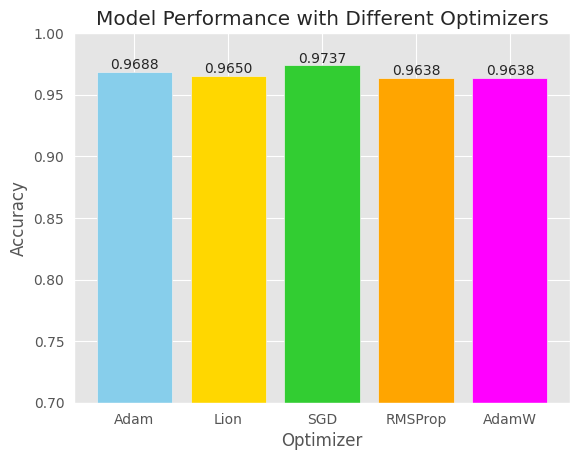

In [ ]:
# Extract accuracies for the bar chart
accuracies = {
    'Adam': vit_results_adam[1],
    'Lion': vit_results_lion[1],
    'SGD': vit_results_sgd[1],
    'RMSProp': vit_results_rms[1],
    'AdamW': vit_results_adamw[1]
}

# Names of optimizers
optimizers = list(accuracies.keys())

# Corresponding accuracy values
accuracy_values = list(accuracies.values())

# Plotting the bar chart
bars = plt.bar(optimizers, accuracy_values, color=['skyblue', 'gold', 'limegreen', 'orange', 'magenta'])

# Adding the title and labels
plt.title('Model Performance with Different Optimizers')
plt.xlabel('Optimizer')
plt.ylabel('Accuracy')
plt.ylim(0.7, 1.0)

# Adding the metrics to each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval,
             f"{yval:.4f}",
             ha='center',
             va='bottom')

# Displaying the bar chart
plt.show()

In [ ]:
# Accuracies dictionary
accuracies = {
    'Adam': vit_results_adam[1],
    'Lion': vit_results_lion[1],
    'SGD': vit_results_sgd[1],
    'RMSProp': vit_results_rms[1],
    'AdamW': vit_results_adamw[1]
}

# Find the optimizer with the highest accuracy
best_optimizer = max(accuracies, key=accuracies.get)
best_accuracy = accuracies[best_optimizer]

# Models dictionary
models = {
    'Adam': vit_model_adam,
    'Lion': vit_model_lion,
    'SGD': vit_model_sgd,
    'RMSProp': vit_model_rms,
    'AdamW': vit_model_adamw
}

# Save the best model
best_model = models[best_optimizer]
best_model.save(f'vit_model_{best_optimizer}.tf')

print(f"Model trained with {best_optimizer} optimizer has the highest accuracy of {best_accuracy:.4f} and has been saved.")

Model trained with SGD optimizer has the highest accuracy of 0.9737 and has been saved.


# New Image Prediction

In [ ]:
# Function to preprocess the image
def preprocess_image(image_path, target_size=(224, 224)):
    try:
        if image_path.startswith('http://') or image_path.startswith('https://'):
            response = requests.get(image_path)
            image = Image.open(BytesIO(response.content))
        else:
            image = Image.open(image_path)

        if image.mode != 'RGB':
            image = image.convert('RGB')

        # Resize the image
        image = image.resize(target_size)

        # Normalize the image
        image_array = np.array(image) / 255.0

        # Add a batch dimension
        image_array = np.expand_dims(image_array, axis=0)

        return image_array

    except Exception as e:
        print(f"Error processing image: {e}")
        return None

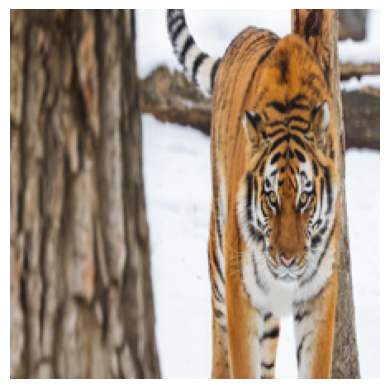

1/1 [==============================] - 3s 3s/step
Predicted class: tiger with probability 0.0296


In [ ]:
# Construct the filename of the best model based on the optimizer
best_model_filename = f'vit_model_{best_optimizer}.tf'

# Load the best model
loaded_model = tf.keras.models.load_model(best_model_filename)

# Path to the image
image_path = 'https://www.calgaryzoo.com/wp-content/uploads/2023/09/BEL_0424.jpg'

# Preprocess the image
preprocessed_array = preprocess_image(image_path, target_size=(224, 224))

# Display the processed image
if preprocessed_array is not None:
    plt.imshow(preprocessed_array[0])
    plt.axis('off')
    plt.show()

# Continue with prediction
if preprocessed_array is not None:
    predictions = loaded_model.predict(preprocessed_array)
    probabilities = tf.nn.softmax(predictions).numpy()
    predicted_class_index = np.argmax(probabilities)
    predicted_class = class_labels[predicted_class_index]
    probability = np.max(probabilities)

    print(f"Predicted class: {predicted_class} with probability {probability:.4f}")